In [77]:
import pandas as pd
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.background import Background2D
import pandas as pd

from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images, split_data_into_channels, merge_channels_into_data
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection

In [62]:
# Plot a cutout of dark calibrated image around a given coordinate

def plot_cutout_around_coordinate(image, wcs, crd, cutout_half_size=10):
    """
    Plot a cutout of the image around a given coordinate.
    :param image:
    :param wcs:
    :param crd:
    :param cutout_half_size:
    :return:
    """
    x, y = wcs.world_to_pixel(crd)
    x, y = int(x), int(y)
    cutout = image[y-cutout_half_size:y+cutout_half_size, x-cutout_half_size:x+cutout_half_size]
    ax = plot_image(cutout)
    # plot an aperture around the coordinate
    aper_radius = 5
    ax.add_patch(plt.Circle((cutout_half_size, cutout_half_size), aper_radius, edgecolor='r', facecolor='none'))
    # add crosses for nans
    nan_locs = np.where(np.isnan(cutout))
    ax.scatter(nan_locs[1], nan_locs[0], marker='x', color='r')


def get_cutout_around_coordinate(image, wcs, crd, cutout_half_size=10):
    """
    Get a cutout of the image around a given coordinate.
    :param image:
    :param wcs:
    :param crd:
    :param cutout_half_size:
    :return:
    """
    x, y = wcs.world_to_pixel(crd)
    x, y = int(x), int(y)
    cutout = image[y-cutout_half_size:y+cutout_half_size, x-cutout_half_size:x+cutout_half_size]
    return cutout

def get_cutout_around_coordinates_from_imagelist(imagelist, astrometried_list, crd, cutout_half_size=10):
    """
    Get a list of cutouts of the image around a given coordinate.
    :param imagelist:
    :param astrometried_list:
    :param crd:
    :param cutout_half_size:
    :return:
    """
    cutout_list = []
    for ind, imagename in enumerate(imagelist):
        image = fits.getdata(imagename)
        wcs = WCS(fits.getheader(astrometried_list[ind]))
        cutout = get_cutout_around_coordinate(image, wcs, crd, cutout_half_size)
        cutout_list.append(cutout)
    return cutout_list


def get_pixel_values_around_coordinate(image, wcs, crd, cutout_half_size=10, aper_radius=5):
    """
    Get the pixel values around a given coordinate.
    :param image:
    :param wcs:
    :param crd:
    :param cutout_half_size:
    :param aper_radius:
    :return:
    """
    x, y = wcs.world_to_pixel(crd)
    x, y = int(x), int(y)
    cutout = image[y-cutout_half_size:y+cutout_half_size, x-cutout_half_size:x+cutout_half_size]
    aperture = np.zeros_like(cutout)
    yy, xx = np.indices(cutout.shape)
    aperture[(xx-cutout_half_size)**2 + (yy-cutout_half_size)**2 < aper_radius**2] = 1
    aperture_values = cutout[aperture==1]
    return aperture_values

def get_pixel_values_around_coordinates_from_imagelist(imagelist, astrometried_list, crd, cutout_half_size=10, aper_radius=5):
    """
    Get the pixel values around a given coordinate for a list of images.
    :param imagelist:
    :param astrometried_list:
    :param crd:
    :param cutout_half_size:
    :param aper_radius:
    :return:
    """
    aperture_values_list = []
    for ind, imagename in enumerate(imagelist):
        image = fits.getdata(imagename)
        wcs = WCS(fits.getheader(astrometried_list[ind]))
        aperture_values = get_pixel_values_around_coordinate(image, wcs, crd, cutout_half_size, aper_radius)
        aperture_values_list.append(aperture_values)
    return aperture_values_list


def plot_cutouts_around_coordinates(imagelist, astrometried_imagelist, crd):
    """
    Plot cutouts of the image around a given coordinate for a list of images.
    :param imagelist:
    :param astrometried_imagelist:
    :param crd:
    :return:
    """
    for ind, imagename in enumerate(imagelist):
        image = fits.getdata(imagename)
        wcs = WCS(fits.getheader(astrometried_imagelist[ind]))
        plot_cutout_around_coordinate(image, wcs, crd)


def apply_bad_pixel_mask_and_save(filelist, maskfile, outdir):
    """
    Apply a bad pixel mask to a list of files and save the masked images to outdir.
    """
    os.makedirs(outdir, exist_ok=True)
    mask = fits.getdata(maskfile)
    for file in filelist:
        data = fits.getdata(file)
        data[mask==1] = np.nan
        outname = os.path.join(outdir, os.path.basename(file))
        write_image(data, filename=outname, header=fits.getheader(file))


def perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15):
    """
    Perform aperture photometry on a list of coordinates.
    :param image:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    image_data = fits.getdata(image)
    wcs = WCS(fits.getheader(astrometry_image))
    # Convert coordinates to pixel coordinates
    crds = crds.to_pixel(wcs)
    xs = crds[0]
    ys = crds[1]
    apertures = CircularAperture(np.column_stack((xs, ys)), r=aper_radius)
    annulus_apertures = CircularAnnulus(np.column_stack((xs, ys)), r_in=annulus_bkg_in, r_out=annulus_bkg_out)

    # Perform aperture photometry
    phot_table = aperture_photometry(image_data, apertures)

    # Perform background subtraction
    bkg_mean = Background2D(image_data, box_size=(50, 50), filter_size=(3, 3)).background_median
    bkg = aperture_photometry(image_data - bkg_mean, annulus_apertures)

    # Subtract background from aperture photometry
    phot_table['aperture_sum'] -= bkg['aperture_sum']

    return phot_table



def perform_aperture_photometry_in_multiple_images(image_list, astrometry_image_list, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15):
    """
    Perform aperture photometry on a list of coordinates for a list of images.
    :param image_list:
    :param astrometry_image_list:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    phot_table_list = []
    for ind, image in enumerate(image_list):
        astrometry_image = astrometry_image_list[ind]
        phot_table = perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius, annulus_bkg_in, annulus_bkg_out)
        phot_table_list.append(phot_table)

    # Add image name to phot_table
    for ind, phot_table in enumerate(phot_table_list):
        phot_table['image'] = os.path.basename(image_list[ind])
        phot_table['astrometry_image'] = os.path.basename(astrometry_image_list[ind])

    # Make final table
    phot_table_list = np.hstack(phot_table_list)
    phot_table_df = pd.DataFrame(phot_table_list)
    return phot_table_df

In [78]:
def get_catalog_mags(crd: SkyCoord, catname: str):
    cat = get_table_from_ldac(catname)
    cat_crds = SkyCoord(cat['ALPHAWIN_J2000'], cat['DELTAWIN_J2000'], unit=u.deg)
    idx, sep, _ = crd.match_to_catalog_sky(cat_crds)
    return cat[idx]['MAG_AUTO'], cat[idx]['MAGERR_AUTO'], cat[idx]['FLUX_AUTO'], cat[idx]['FLUXERR_AUTO'], cat[idx]['XWIN_IMAGE'], cat[idx]['YWIN_IMAGE'], sep.to(u.arcsec).value

def get_catalog_mags_from_list(crds, catlist):
    mags = []
    magerrs = []
    fluxes = []
    fluxerrs = []
    xs, ys = [], []
    seps = []
    for catname in catlist:
        mag, magerr, flux, fluxerr, x, y, sep = get_catalog_mags(crds, catname)
        mags.append(mag)
        magerrs.append(magerr)
        fluxes.append(flux)
        fluxerrs.append(fluxerr)
        xs.append(x)
        ys.append(y)
        seps.append(sep)
    mags = np.array(mags)
    magerrs = np.array(magerrs)
    fluxes = np.array(fluxes)
    fluxerrs = np.array(fluxerrs)
    xs = np.array(xs)
    ys = np.array(ys)
    return mags, magerrs, fluxes, fluxerrs, xs, ys, seps


def xmatch_cat_to_2mass(img_catname, tm_catname):
    cat = get_table_from_ldac(img_catname)
    cat = cat[cat['MAG_AUTO']<99]
    tmass_cat = get_table_from_ldac(tm_catname)
    cat_crds = SkyCoord(cat['ALPHAWIN_J2000'], cat['DELTAWIN_J2000'], unit=u.deg)
    tmass_crds = SkyCoord(tmass_cat['RA_ICRS'], tmass_cat['DE_ICRS'], unit=u.deg)
    id1, id2, d2d, d3d = cat_crds.search_around_sky(tmass_crds, 2*u.arcsec)
    tm_matched = tmass_cat[id1]
    cat_matched = cat[id2]
    return cat_matched, tm_matched

In [2]:
base_dir = Path("/Users/viraj/winter_data/winter/hackathon_datasets")
print(base_dir)
name = 'ZTF25aadlqhw'
night = '20250220'
boardid = 4

target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

/Users/viraj/winter_data/winter/hackathon_datasets


In [3]:
dark_calibrated_list = np.sort(glob(str(target_dir.joinpath('darkcal/*fits'))))
astrometried_list = np.sort(glob(str(target_dir.joinpath('post_scamp/*fits'))))
flat_calibrated_list = np.sort(glob(str(target_dir.joinpath('skyflatcal/*fits'))))
raw_unpacked_list = np.sort(glob(str(target_dir.joinpath('raw_unpacked/*fits'))))

In [4]:
# Gather astrometry headers for all images
scamp_headers = [fits.getheader(astrometried) for astrometried in astrometried_list]


In [12]:
src_crd = SkyCoord(ra=[224.94733], dec=[51.44949], unit=(u.deg, u.deg))

In [27]:
perform_aperture_photometry_on_coordinates(flat_calibrated_list[0], astrometried_list[0], src_crd)

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,859.6160377850533,638.4264305349154,267467.36271151865


In [28]:
ref_cat = get_tmass_gaia_catalog_for_image(astrometried_list[0], write_catalog=True, write_regions=True)

SELECT * FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid AND CONTAINS(POINT('ICRS', g.ra, g.dec), CIRCLE('ICRS', 224.8942, 51.4746, 0.2500))=1 AND tmass.j_m > 7.00 AND tmass.j_m < 20.00 AND tbest.number_of_mates=0 AND tbest.number_of_neighbours=1;
INFO: Query finished. [astroquery.utils.tap.core]
Yay


In [57]:
bright_ref_cat = ref_cat[(ref_cat['j_m']<13) & (ref_cat['j_m']>12.5)]

In [58]:
bright_ref_cat_crds = SkyCoord(ra=bright_ref_cat['ra'], dec=bright_ref_cat['dec'], unit=(u.deg, u.deg))
flat_phot_table = perform_aperture_photometry_on_coordinates(flat_calibrated_list[0], astrometried_list[0], bright_ref_cat_crds)

In [59]:
in_image_mask = (flat_phot_table['xcenter'].value >= 100) & (flat_phot_table['xcenter'].value < 2000) & (flat_phot_table['ycenter'].value >= 100) & (flat_phot_table['ycenter'].value < 1000)
flat_phot_table = flat_phot_table[in_image_mask]

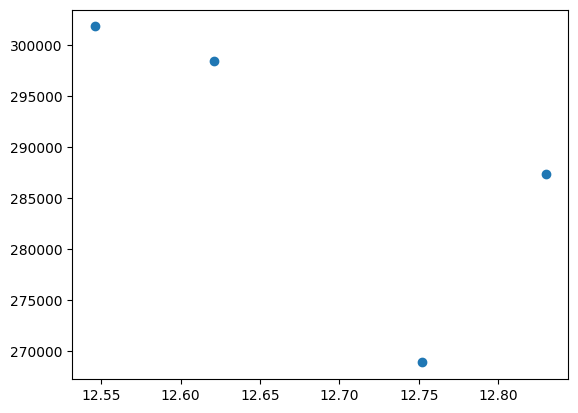

In [60]:
plt.plot(bright_ref_cat['j_m'][in_image_mask], flat_phot_table['aperture_sum'], 'o')

In [73]:
phot_df = perform_aperture_photometry_in_multiple_images(flat_calibrated_list, astrometried_list, bright_ref_cat_crds)

In [74]:
phot_df_groups = phot_df.groupby('id')

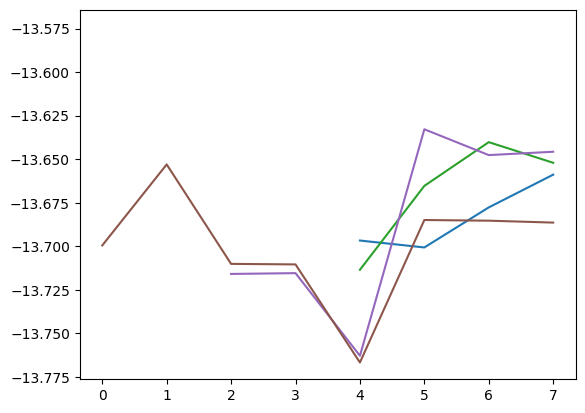

In [76]:
# plot photometry for each group
for name, group in phot_df_groups:
    plt.plot(-2.5*np.log10(group['aperture_sum'].values), label=name)

In [95]:
# Assign an astrometry header from the post_scamp directory to this file and write it.
skysub_list = np.sort(glob(str(target_dir.joinpath('skysub/*_4_0_0.fits'))))
for ind, skysub_name in enumerate(skysub_list):
    skysub_scamped_filename = skysub_name.replace('skysub', 'skysub_scamped')
    skysub_img = fits.getdata(skysub_name)
    scamp_astrometry_header= fits.getheader(astrometried_list[ind])
    write_image(image=skysub_img, header=scamp_astrometry_header, filename=skysub_scamped_filename)

In [99]:
# Run sextractor on all skysub images
skysub_scamped_list = np.sort(glob(str(target_dir.joinpath('skysub_scamped/*_4_0_0.fits'))))
for skysub_file in skysub_scamped_list:
    run_sextractor(skysub_file)

Executing command : sex -c /Users/viraj/winterdrp_offline/winterdrp_offline/config/astrom.sex /Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072719-143_mef_4_0_0.fits -CATALOG_NAME /Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072719-143_mef_4_0_0.fits.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME /Users/viraj/winterdrp_offline/winterdrp_offline/config/astrom.param -FILTER_NAME /Users/viraj/winterdrp_offline/winterdrp_offline/config/default.conv -STARNNW_NAME /Users/viraj/winterdrp_offline/winterdrp_offline/config/default.nnw -PIXEL_SCALE 1.12 -DETECT_THRESH 3.0 -ANALYSIS_THRESH 3.0 -SATUR_LEVEL 60000.0 -WEIGHT_TYPE MAP_WEIGHT -WEIGHT_IMAGE /Users/viraj/winter_data/winter/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072719-143_mef_4_0_0_weight.fits -CHECKIMAGE_TYPE BACKGROUND,-BACKGROUND -CHECKIMAGE_NAME /Users/viraj/winter

In [104]:
# Load SExtractor catalogs
catalogs_list = glob(target_dir.joinpath('skysub_scamped/*.clean.cat').as_posix())
print(len(catalogs_list))

8


In [105]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, catalogs_list)

Text(0, 0.5, 'Frame #')

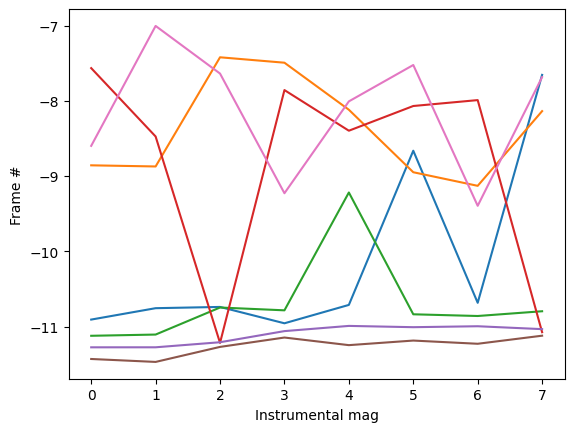

In [108]:
plt.plot(mags)
plt.xlabel(r'Instrumental mag')
plt.ylabel(r'Frame #')